For every output, the input sets may not be the same.

In [2]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist

import tqdm

In [3]:
class ExactGP(gpytorch.models.ExactGP):
            
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[-1])
            # gpytorch.kernels.RBFKernel() # default ard_num_dims=None. All dims have same length scale
        )
                
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
N = 100
D = 2
train_x = torch.empty((N,D))
train_y = torch.empty((N,))

In [5]:
# initialise the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood)

In [6]:
# if no ard_num_dims set, then length scale will have shape 1, instead of shape D
print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.base_kernel.lengthscale.shape[-1] == D)

tensor([[0.6931, 0.6931]], grad_fn=<SoftplusBackward0>)
True


In [7]:
model.mean_module.constant

Parameter containing:
tensor(0., requires_grad=True)

In [8]:
hypers = [
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(8.),
        'covar_module.base_kernel.lengthscale': torch.tensor([1., .75]),
        'mean_module.constant': torch.tensor([5.])
    }, 
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(5.),
        'covar_module.base_kernel.lengthscale': torch.tensor([.9, .2]),
        'mean_module.constant': torch.tensor([9.])
    }
]

In [9]:
# def random_slice(low, high, size, exclude_pts=None):

#     if not exclude_pts:
#         idx = torch.randint(low, high, size)
#         idx = torch.tensor(np.sort(idx))
#     else:
#         l_exclude, r_exclude = exclude_pts
#         l_size, r_size = size
#         idx = torch.concat([torch.randint(low, l_exclude, l_size), 
#                             torch.randint(r_exclude, high, r_size)])
    
#     return idx
# torch.manual_seed(28)
# idx = [random_slice(0,N,size=[(76,), (80,)], exclude_pts=(.55, )),
#        random_slice(0,N,size=(88,)),
#        random_slice(0,N,size=(105,),exclude_pts=None)]

In [10]:
x1 = torch.linspace(0, 1, N)
x2 = torch.linspace(0, 1, N)

x1_grid, x2_grid = torch.meshgrid([x1, x2])
X_grid = torch.cat(tuple(torch.dstack([x1_grid, x2_grid])))

Y_surface = torch.empty((N**2,2))

model.initialize(**hypers[0])

model.eval()

torch.manual_seed(55)
with gpytorch.settings.prior_mode(True):
    Y_surface[:,0] = model(X_grid).sample()

model.initialize(**hypers[1])
torch.manual_seed(88)
with gpytorch.settings.prior_mode(True):
    Y_surface[:,1] = model(X_grid).sample()

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
model.covar_module.base_kernel.lengthscale

tensor([[0.9000, 0.2000]], grad_fn=<SoftplusBackward0>)

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

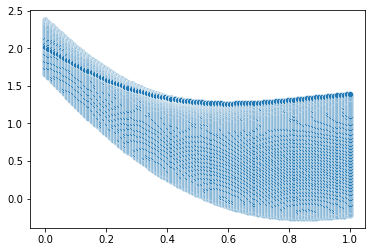

In [12]:
sns.scatterplot(X_grid[:,0], Y_surface[:,0])

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

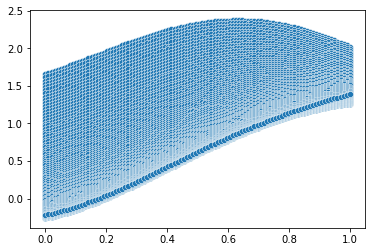

In [13]:
sns.scatterplot(X_grid[:,1], Y_surface[:,0])

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

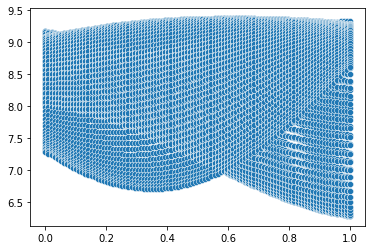

In [14]:
sns.scatterplot(X_grid[:,0], Y_surface[:,1])

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

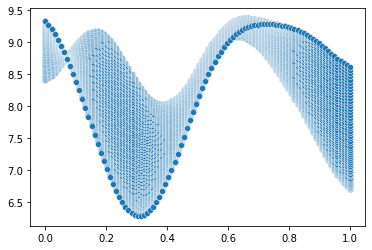

In [15]:
sns.scatterplot(X_grid[:,1], Y_surface[:,1])

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

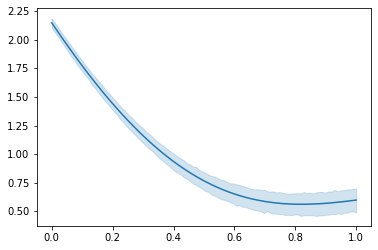

In [17]:
sns.lineplot(X_grid[:,0], Y_surface[:,0])

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

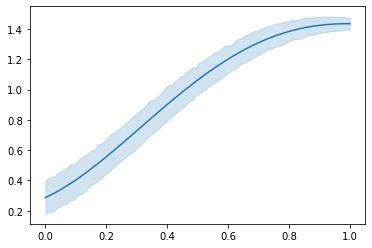

In [18]:
sns.lineplot(X_grid[:,1], Y_surface[:,0])

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

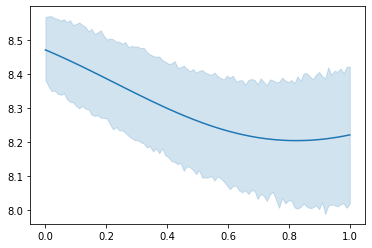

In [19]:
sns.lineplot(X_grid[:,0], Y_surface[:,1])

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

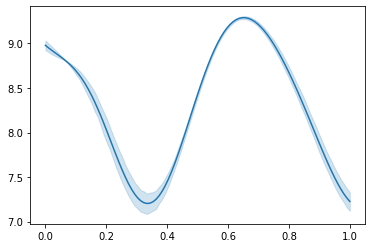

In [20]:
sns.lineplot(X_grid[:,1], Y_surface[:,1])

Text(0.5, 0, 'f(x)')

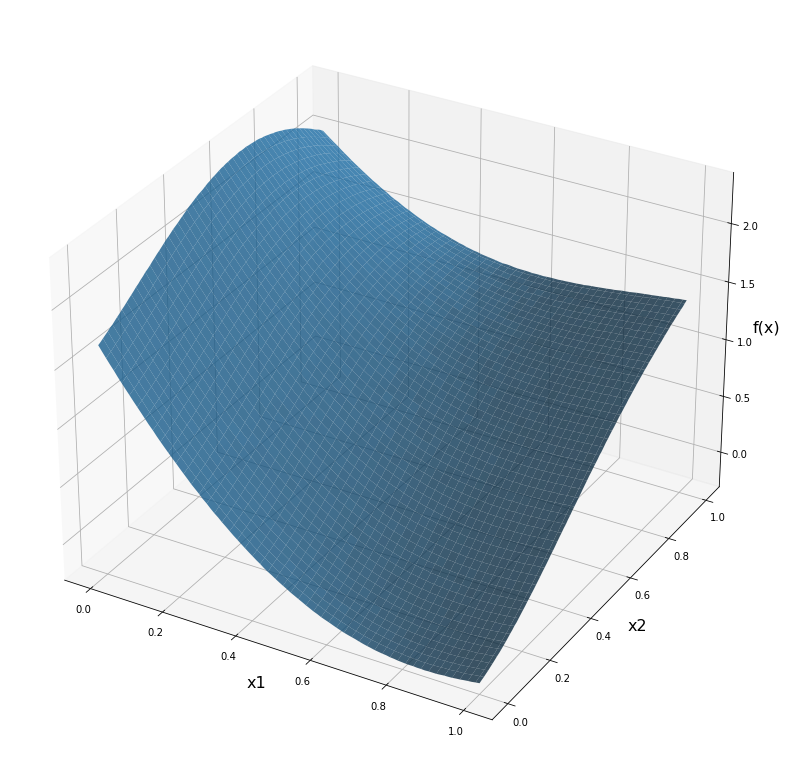

In [50]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_grid.numpy(), x2_grid.numpy(), Y_surface[:,0].reshape((N, N)).numpy(), alpha=.8)
ax.set_xlabel("x1", fontsize=16)
ax.set_ylabel("x2", fontsize=16)
ax.set_zlabel("f(x)", fontsize=16)

Text(0.5, 0, 'f(x)')

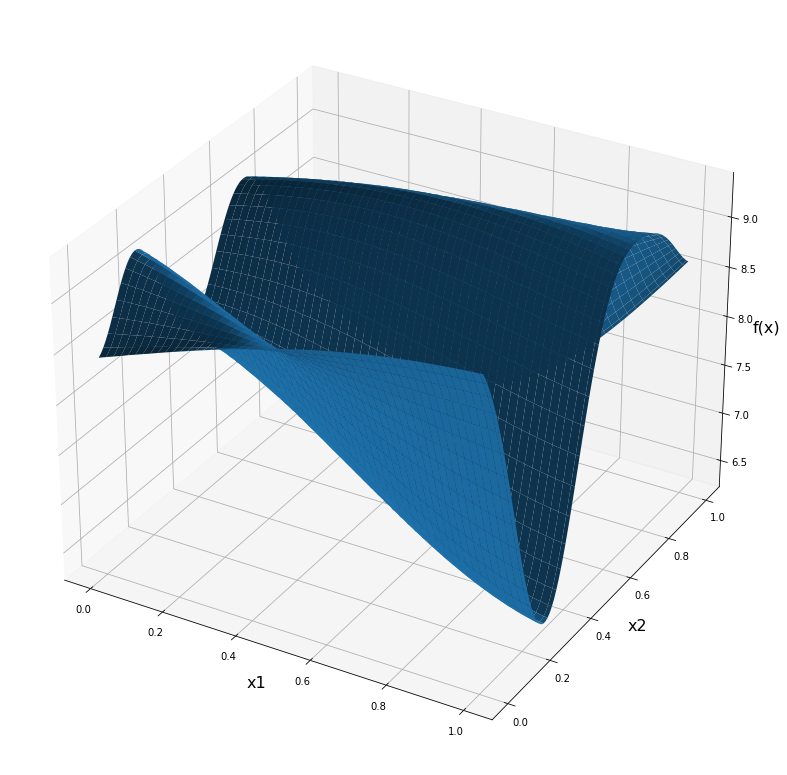

In [22]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_grid.numpy(), x2_grid.numpy(), Y_surface[:,1].reshape((N, N)).numpy())
ax.set_xlabel("x1", fontsize=16)
ax.set_ylabel("x2", fontsize=16)
ax.set_zlabel("f(x)", fontsize=16)

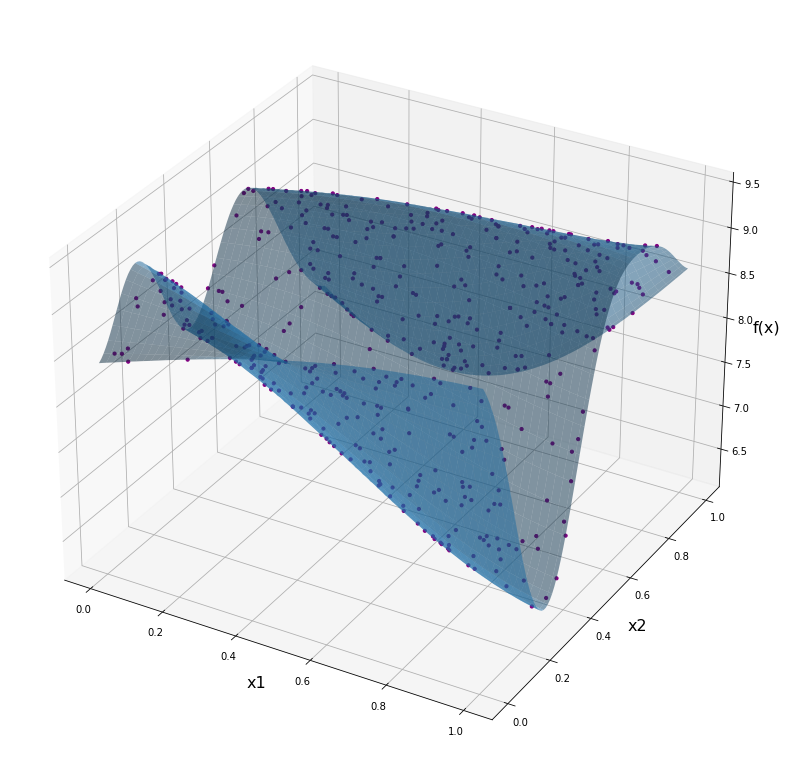

In [23]:
torch.manual_seed(88)
idx = torch.randint(0,10000,(500,))

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_grid.numpy(), x2_grid.numpy(), Y_surface[:,1].reshape((N, N)).numpy(), alpha=.5)
ax.set_xlabel("x1", fontsize=16)
ax.set_ylabel("x2", fontsize=16)
ax.set_zlabel("f(x)", fontsize=16)

# ax.scatter(x1_grid.gather(0,subset_idx).numpy(), x2_grid.gather(0,subset_idx).numpy(), Y_surface[:,1].reshape((N, N)).gather(0,subset_idx).numpy(), color='red')
ax.scatter(x1_grid.flatten().numpy()[idx], x2_grid.flatten().numpy()[idx], Y_surface[:,1].numpy()[idx], color='purple', alpha=.99, s=10)

In [ ]:
x1_grid.flatten().numpy()[idx], x2_grid.flatten().numpy()[idx], Y_surface[:,1].numpy()[idx]

Text(0, 0.5, 'f(x)')

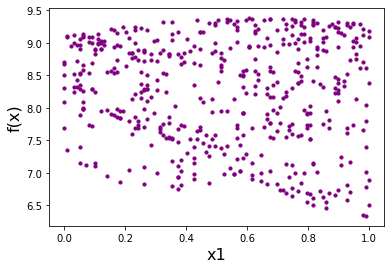

In [31]:
fig, ax = plt.subplots()

ax.scatter(x1_grid.flatten().numpy()[idx], Y_surface[:,1].numpy()[idx],
           color='purple', alpha=.99, s=10)

ax.set_xlabel("x1", fontsize=16)
ax.set_ylabel("f(x)", fontsize=16)

Text(0, 0.5, 'f(x)')

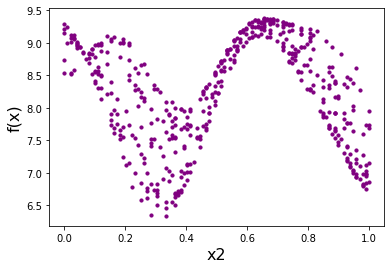

In [32]:
fig, ax = plt.subplots()

ax.scatter(x2_grid.flatten().numpy()[idx], Y_surface[:,1].numpy()[idx],
           color='purple', alpha=.99, s=10)

ax.set_xlabel("x2", fontsize=16)
ax.set_ylabel("f(x)", fontsize=16)

In [41]:
logit = lambda x: 1 / (1 + np.exp(-x))
exp = lambda x: np.exp(x)

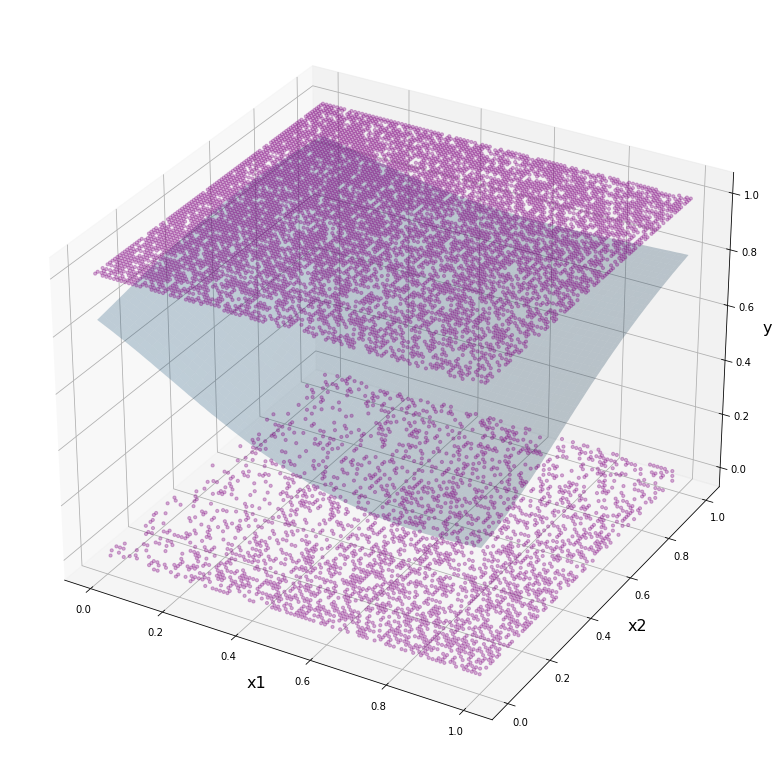

In [47]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_grid.numpy(), x2_grid.numpy(), logit(Y_surface[:,0]).reshape((N, N)).numpy(), alpha=.25)
ax.set_xlabel("x1", fontsize=16)
ax.set_ylabel("x2", fontsize=16)
ax.set_zlabel("y", fontsize=16)

ax.scatter(x1_grid.flatten().numpy(), x2_grid.flatten().numpy(), dist.Bernoulli(logit(Y_surface[:,0]))().numpy(), color='purple', alpha=.3, s=10)

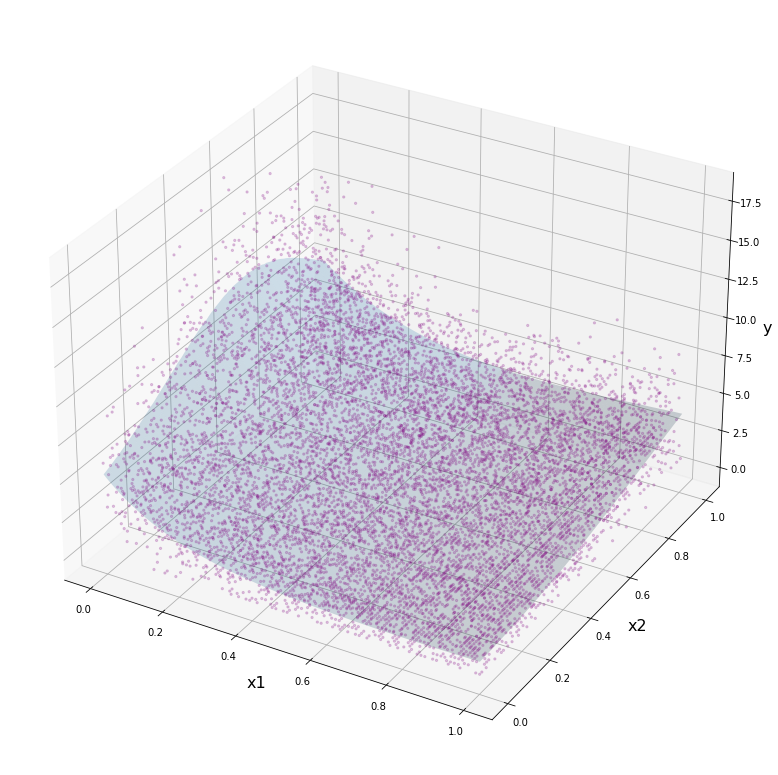

In [48]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_grid.numpy(), x2_grid.numpy(), exp(Y_surface[:,0]).reshape((N, N)).numpy(), alpha=.2)
ax.set_xlabel("x1", fontsize=16)
ax.set_ylabel("x2", fontsize=16)
ax.set_zlabel("y", fontsize=16)

ax.scatter(x1_grid.flatten().numpy(), x2_grid.flatten().numpy(), dist.Poisson(exp(Y_surface[:,0]))().numpy(), color='purple', alpha=.2, s=5)

In [115]:
A = torch.tensor([
    [1.1, -0.7, -1.1, .55], # A_1
    [-.5, 0.69, .12, -.22], # A_2
]).T
A

tensor([[ 1.1000, -0.5000],
        [-0.7000,  0.6900],
        [-1.1000,  0.1200],
        [ 0.5500, -0.2200]])

In [116]:
B_1 = A[:,0].unsqueeze(1) @ A[:,0].unsqueeze(0)
B_2 = A[:,1].unsqueeze(1) @ A[:,1].unsqueeze(0)

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

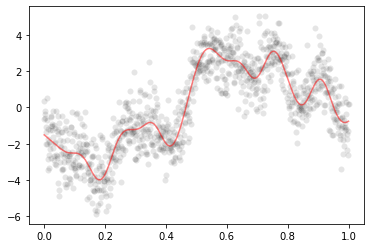

In [118]:
torch.manual_seed(55)

# f_11 = a_11*g_11(Y)
# y_1 = torch.bernoulli(f_11)

f_11 = Y @ A[0,:]
y_1 = torch.normal(f_11, 1)
# ys_1 = y_1[idx[0]]
# Xs_1 = X[idx[0]]

sns.lineplot(X, f_11, color='red', alpha=.5)
sns.scatterplot(X, y_1, color='black', alpha=.1)
# sns.scatterplot(Xs_1, ys_1, color='black', alpha=.1)

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

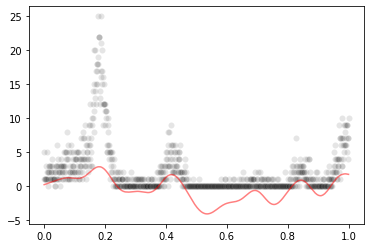

In [119]:
torch.manual_seed(55)
a_21 = -0.7

# f_21 = a_21*g_21(Y)
# y_2 = torch.poisson(f_21)

f_21 = Y @ A[1,:]
# y_2 = torch.normal(f_21, .2)
y_2 = dist.Poisson(f_21.exp())()

sns.lineplot(X, f_21, color='red', alpha=.5)
sns.scatterplot(X, y_2, color='black', alpha=.1)

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

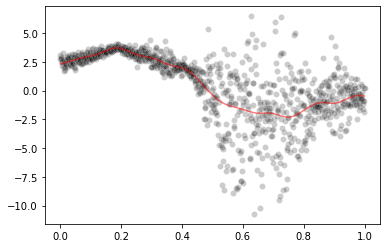

In [120]:
torch.manual_seed(55)

# f_31 = a_31*g_31(Y)
# f_32 = a_32*g_32(Y)
# y_3 = torch.normal(f_31, f_32)

# sns.scatterplot(X, y_3, color='black', alpha=.2)
# sns.lineplot(X, f_31, color='red', alpha=.5)
# sns.lineplot(X, f_32, color='blue', alpha=.5)

f_31 = Y @ A[2,:]
f_32 = Y @ A[3,:]
y_3 = torch.normal(f_31, f_32.exp())
# y_3 = torch.normal(f_31, .7)

sns.scatterplot(X, y_3, color='black', alpha=.2)
sns.lineplot(X, f_31, color='red', alpha=.5)

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or m

<AxesSubplot:>

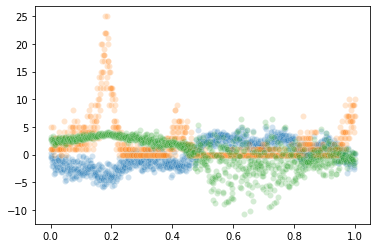

In [121]:
sns.scatterplot(X, y_1, alpha=.2)
sns.scatterplot(X, y_2, alpha=.2)
sns.scatterplot(X, y_3, alpha=.2)

## Example of training model setting num_latents = 1

In [341]:
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_tasks, num_latents=1, name_prefix="lmc_mogp"):
        
        self.name_prefix = name_prefix
        
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.linspace(0, 1, 16)

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-1), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )

        super().__init__(variational_strategy=variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def guide(self, x, y):
         # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x)
        assert function_dist.batch_shape == (1000,)

        # Use a plate here to mark conditional independencies
        # with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
        
            
    def model(self, x, y):
        pyro.module(self.name_prefix + ".gp", self)

        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x)

        # Use a plate here to mark conditional independencies
        # with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
            
            # print(function_samples)
            # Sample from observed distribution
            pyro.sample(
                self.name_prefix + ".y_1",
                dist.Normal(f[...,0], torch.tensor(1.)).to_event(1),
                obs=y[...,0]
            )
            
            pyro.sample(
                self.name_prefix + ".y_2",
                dist.Poisson(f[...,1].exp()).to_event(1),
                obs=y[...,1]
            )
            
            pyro.sample(
                self.name_prefix + ".y_3",
                dist.Normal(f[...,2], f[...,3].exp()).to_event(1),
                obs=y[...,2]
            )
        # print(dist.Normal(function_samples, torch.tensor(1.)).log_prob(y))
            # print(dist.Normal(function_samples, torch.tensor(1.)).shape())

In [342]:
train_x = X
train_y = torch.stack([y_1, y_2, y_3], dim=-1)
# train_y = torch.stack([y_1, y_2], dim=-1)
# train_y = y_1

In [343]:
model = MultitaskGPModel(inducing_points=train_x, num_tasks=4, num_latents=1)
# likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)

In [344]:
pyro.clear_param_store()

num_iter = 300
num_particles = 256

optimizer = pyro.optim.Adam({"lr": 0.01})
# elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
elbo = pyro.infer.Trace_ELBO(vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter))
loss_list = []
for i in iterator:
    model.zero_grad()
    loss = svi.step(train_x, train_y)
    loss_list.append(loss)
    iterator.set_postfix(loss=loss)

  0%|          | 0/300 [00:00<?, ?it/s]

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

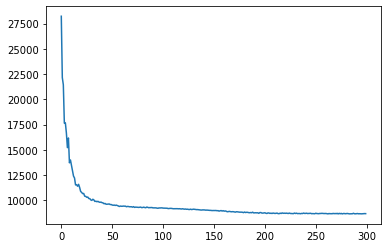

In [345]:
sns.lineplot(np.arange(0, len(loss_list)), loss_list)

In [346]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [347]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
test_x = torch.linspace(0, 1, N).float()#.cuda()

model.eval()
with torch.no_grad():
    output = model(test_x)

# Get E[exp(f)] via f_i ~ GP, 1/n \sum_{i=1}^{n} exp(f_i).
# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([1000]))
lower, mean, upper = percentiles_from_samples(samples)

# Draw some simulated y values
mu_sim = model(train_x)()
y_sim = torch.stack(
    [dist.Normal(mu_sim[:,0].detach(), torch.tensor(1.))(),
     dist.Poisson(mu_sim[:,1].detach().exp())(), 
     dist.Normal(mu_sim[:,2].detach(), mu_sim[:,3].detach().exp())()],
    dim=-1
)

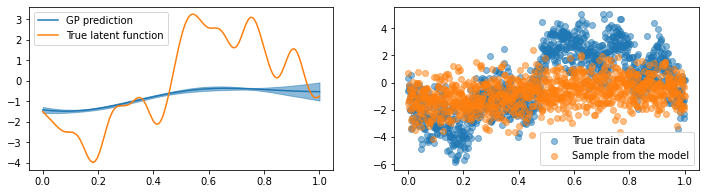

In [348]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,0].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,0].squeeze().detach().cpu().numpy(),
    upper[:,0].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_11, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,0], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,0].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

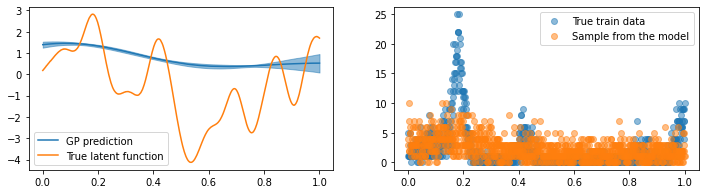

In [349]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,1].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,1].squeeze().detach().cpu().numpy(),
    upper[:,1].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_21, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,1], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,1].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

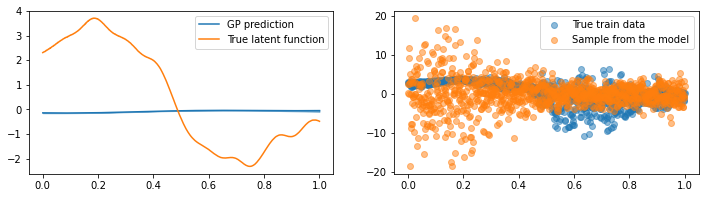

In [350]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,2].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,2].squeeze().detach().cpu().numpy(),
    upper[:,2].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_31, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,2], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,2].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

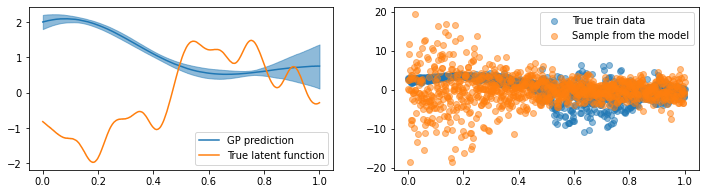

In [351]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,3].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,3].squeeze().detach().cpu().numpy(),
    upper[:,3].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_32, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,2], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,2].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

In [352]:
# unit lmc coefficient vector is more interpretable
# we can compare this with the lmc coefficient vector from torch model
A.T / A.T.norm(dim=-1).unsqueeze(-1)

tensor([[ 0.6137, -0.3905, -0.6137,  0.3069],
        [-0.5629,  0.7769,  0.1351, -0.2477]])

In [353]:
# unit lmc coefficient vector is more interpretable
model.variational_strategy.lmc_coefficients.detach() / model.variational_strategy.lmc_coefficients.detach().norm(dim=-1).unsqueeze(-1)

tensor([[ 0.5040, -0.4912,  0.0487, -0.7088]])

## Example of training model setting num_latents = 2

In [354]:
model = MultitaskGPModel(inducing_points=train_x, num_tasks=4, num_latents=2)
# likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)

In [363]:
pyro.clear_param_store()

num_iter = 500
num_particles = 256

optimizer = pyro.optim.Adam({"lr": 0.01})
# elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
elbo = pyro.infer.Trace_ELBO(vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter))
loss_list = []
for i in iterator:
    model.zero_grad()
    loss = svi.step(train_x, train_y)
    loss_list.append(loss)
    iterator.set_postfix(loss=loss)

  0%|          | 0/500 [00:00<?, ?it/s]

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

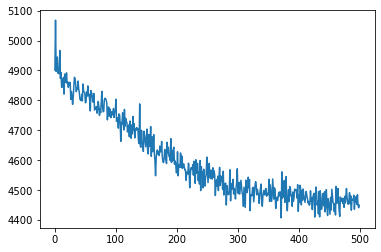

In [364]:
sns.lineplot(np.arange(0, len(loss_list)), loss_list)

In [365]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [366]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
test_x = torch.linspace(0, 1, N).float()#.cuda()

model.eval()
with torch.no_grad():
    output = model(test_x)

# Get E[exp(f)] via f_i ~ GP, 1/n \sum_{i=1}^{n} exp(f_i).
# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([1000]))
lower, mean, upper = percentiles_from_samples(samples)

# Draw some simulated y values
mu_sim = model(train_x)()
y_sim = torch.stack(
    [dist.Normal(mu_sim[:,0].detach(), torch.tensor(1.))(),
     dist.Poisson(mu_sim[:,1].detach().exp())(), 
     dist.Normal(mu_sim[:,2].detach(), mu_sim[:,3].detach().exp())()],
    dim=-1
)

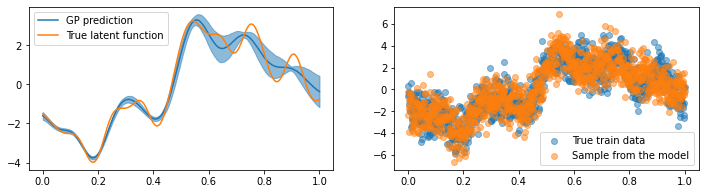

In [367]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,0].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,0].squeeze().detach().cpu().numpy(),
    upper[:,0].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_11, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,0], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,0].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

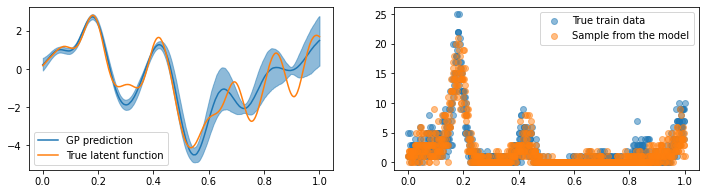

In [368]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,1].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,1].squeeze().detach().cpu().numpy(),
    upper[:,1].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_21, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,1], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,1].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

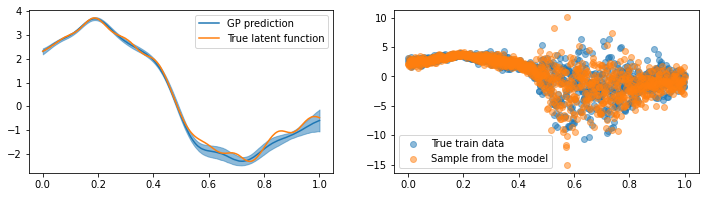

In [369]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,2].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,2].squeeze().detach().cpu().numpy(),
    upper[:,2].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_31, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,2], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,2].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

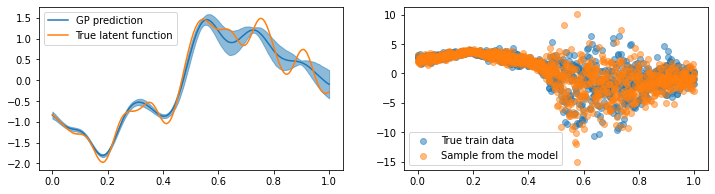

In [370]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,3].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,3].squeeze().detach().cpu().numpy(),
    upper[:,3].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_32, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,2], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,2].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

In [371]:
# unit lmc coefficient vector is more interpretable
# we can compare this with the lmc coefficient vector from torch model
A.T / A.T.norm(dim=-1).unsqueeze(-1)

tensor([[ 0.6137, -0.3905, -0.6137,  0.3069],
        [-0.5629,  0.7769,  0.1351, -0.2477]])

In [372]:
# unit lmc coefficient vector is more interpretable
model.variational_strategy.lmc_coefficients.detach() / model.variational_strategy.lmc_coefficients.detach().norm(dim=-1).unsqueeze(-1)

tensor([[ 0.5052, -0.8258, -0.1328,  0.2126],
        [ 0.2598,  0.5070, -0.8037,  0.1717]])